# Parameters optimization for Model 1
The optimized parameters are 
    mda,
    mdw,
    UAr2d,
    UAs2Fe,
    UAFe2a.


In [89]:
# Parameter optimization
#Filename:ParameterOptimization.ipynb
#Author:Madhusudhan Pandey, USN, EPE
using DataFrames
using CSV
using Taro
using Plots
pyplot();
df=CSV.read("realdata.csv")#,"F6:H654")
#load If, It, Twc
df_input = df[70:653, [:Column6, :Column13, :Column11 ]]
df_output = df[70:653, [:Column7, :Column8]]
df_water_temp = df[70:653, [:Column10, :Column9]]
If, It, Twc = df_input[1],df_input[2],df_input[3]
Ts_meas, TFe_meas = df_output[1], df_output[2]
Tac, Tah = df_water_temp[1],df_water_temp[2]
# All data are combination of string and missing so converting
# it back to float64
If_float, It_float, Twc_float,Ts_meas_float, TFe_meas_float =zeros(584),zeros(584),zeros(584),zeros(584),zeros(584)
Tac_meas_float, Tah_meas_float = zeros(584), zeros(584)
for i in range(1,step=1,584)
    If_float[i]=parse(Float64, If[i])
    It_float[i]=parse(Float64, It[i])
    Twc_float[i]=parse(Float64, Twc[i])
    Ts_meas_float[i]=parse(Float64, Ts_meas[i])
    TFe_meas_float[i]=parse(Float64, TFe_meas[i])
    Tac_meas_float[i]=parse(Float64, Tac[i])
    Tah_meas_float[i]=parse(Float64, Tah[i])
end
Ifd=If_float
It = It_float
Twc = Twc_float
# Datas for optimization
data=zeros(2,584)
for i in range(1,stop=584)
    data[1,i]=Ts_meas_float[i]
    data[2,i]=TFe_meas_float[i]
end

In [159]:
using DiffEqSensitivity
using DifferentialEquations
using DiffEqParamEstim
using OrdinaryDiffEq
using ODE
#Parameter optimization
using LinearAlgebra
using Plots
using Plots.PlotMeasures
using LaTeXStrings
pyplot();
# Linewidths and styles
LW1 = 2 
LW2 = 1.5
LS1 = :solid
LS2 = :dot
LS3 = :dashdot
LS4 = :dash;
function u_Ifd(t)
    # Iterative value of Twc from real data
    t=trunc(Int,t/60+1)
    return Ifd[t]
end
function u_It(t)
    # Iterative value of Twc from real data
    t=trunc(Int,t/60+1)
    return It[t]
end
function u_Twc(t)
    # Iterative value of Twc from real data
    t=trunc(Int,t/60+1)
    return Twc[t]
end

function gen(dx,x,p,t)
    # unpacking states
    Tr = x[1]
    Ts = x[2]
    TFe = x[3]
    # upacking inputs
    mda = p[1]
    mdw = p[2]
    UAr2d = p[3]
    UAs2Fe = p[4]
    UAFe2a = p[5]
    QdFes = 212.
    Wdf = 528.
    mr = 9260.
    ms = 6827.
    mFe = 71200.
    hAax = 55.6
    hAwx = 222.
    Rr = 0.127e-3
    Rs = 1.95e-6
    #alphaCu = 0.00404
    Twc = u_Twc(t)
    Ifd = u_Ifd(t)
    It = u_It(t)
    chpa = 1.012
    chpw = 4.1813
    chpCu = 0.385
    chpFe = 0.412 

    UAx = 1/(1/hAax+1/hAwx)
    
    Qdfs = 0.8*Wdf
    # Stanton numbers
    NSta = UAx/chpa/mda
    NStw = UAx/chpw/mdw
    NStd = NStw - NSta
    # Matrices
    M1 = diagm(0=>[mr*chpCu , ms*chpCu , mFe*chpFe])
    M2 = [-UAr2d 0. 0.; 0. -UAs2Fe UAs2Fe; 0. UAs2Fe -UAs2Fe-UAFe2a]
    M3 = [0. UAr2d 0.; 0. 0. 0.; 0. 0. UAFe2a]
    #
    N1 = [-mda*chpa mda*chpa+UAr2d 0.; 0. -mda*chpa mda*chpa+UAFe2a; NStw-NSta*exp(-NStd) 0. -NStd]
    N2 = [UAr2d 0. 0.; 0. 0. UAFe2a; 0. 0. 0.]
    #
    v = [1.1*Rr*u_Ifd(t)^2, 3*Rs*u_It(t)^2, QdFes]
    w = [Qdfs, 0., NSta*(1-exp(-NStd))*u_Twc(t)]
    #
    z = N1\(N2*x + w)
    dxdt = M1\(M2*x+M3*z + v)
    dx[1],dx[2],dx[3]=dxdt
end
# Parameters
# p = [mda,mdw,UAr2d,UAs2Fe,UAFe2a,QdFes,Wdf,mr,ms,mFe,hAax,hAwx]
p = [53.9,49.2,2.7,20,14.3] 
# Initial values
x0 = [28.,28.,28.]
# Time span
tspan = (0, 583*60.)

prob = ODEProblem(gen,x0,tspan,p)
sol = solve(prob, ABM54(), dt=60);

retcode: Success
Interpolation: 3rd order Hermite
t: 584-element Array{Float64,1}:
     0.0
    60.0
   120.0
   180.0
   240.0
   300.0
   360.0
   420.0
   480.0
   540.0
   600.0
   660.0
   720.0
     ⋮  
 34320.0
 34380.0
 34440.0
 34500.0
 34560.0
 34620.0
 34680.0
 34740.0
 34800.0
 34860.0
 34920.0
 34980.0
u: 584-element Array{Array{Float64,1},1}:
 [28.0, 28.0, 28.0]         
 [28.8928, 29.2728, 28.2816]
 [29.7519, 30.2014, 28.5913]
 [30.5776, 30.9051, 28.9159]
 [31.3714, 31.4862, 29.2479]
 [32.1347, 31.9663, 29.583] 
 [32.866, 32.3922, 29.9171] 
 [33.5605, 32.7599, 30.2488]
 [34.2255, 33.1152, 30.5759]
 [34.864, 33.4303, 30.8986] 
 [35.4669, 33.7189, 31.2151]
 [36.0368, 34.0012, 31.5251]
 [36.5793, 34.2721, 31.8288]
 ⋮                          
 [65.746, 64.4383, 58.0118] 
 [65.72, 64.4238, 58.006]   
 [65.695, 64.4032, 57.9999] 
 [65.6643, 64.3615, 57.993] 
 [65.6187, 64.3437, 57.9847]
 [65.5818, 64.334, 57.9767] 
 [65.5434, 64.3251, 57.9686]
 [65.5072, 64.3171, 57.9606]
 [6

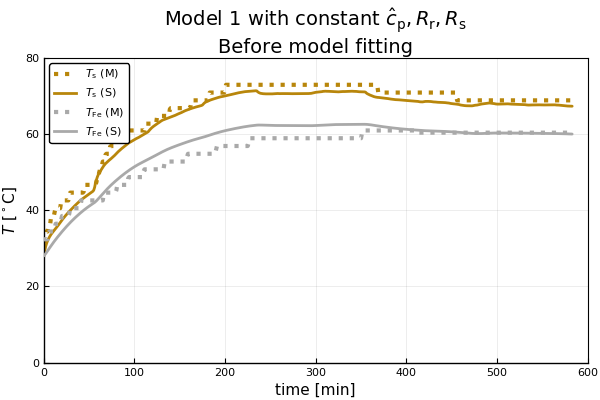

In [157]:
plot(sol.t/60,Ts_meas_float,label=L"T_\mathrm{s}\ \mathrm{(M)}",lc=:darkgoldenrod,lw=3,ls=:dot)
plot!(sol.t/60,sol[2,:], label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
Model1Ts=plot!(xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,600),framestyle = :box)

plot!(sol.t/60,TFe_meas_float,label=L"T_\mathrm{Fe}\ \mathrm{(M)}",lc=:darkgrey,lw=3,ls=:dot )
plot!(sol.t/60,sol[3,:], label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
Model1TFe=plot!(xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,600),framestyle = :box)

Model1beforeFitting=plot!(title=string("Model 1 with constant ", "\$\\hatc_\\mathrm{p},R_\\mathrm{r},R_\\mathrm{s}\$\nBefore model fitting"),
    xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,600),ylim=(0,80),framestyle = :box,legend=:topleft)


In [110]:
# Stator ard iron temperature data for loss function
data

2×584 Array{Float64,2}:
 31.4186  32.3701  32.9818  34.4092  …  68.8184  68.8184  68.8184  68.8184
 32.3701  32.3701  32.3701  32.3701     60.3393  60.3393  60.3393  60.3393

In [111]:
# Building a cost function for optimization
t = collect(range(0,stop=583,length=584))
cost_function = build_loss_objective(prob,ABM54(),dt=60.,save_idxs=2:3,L2Loss(t,data),
                                     maxiters=10000,verbose=false)

(::DiffEqObjective{getfield(DiffEqParamEstim, Symbol("##29#34")){Nothing,Bool,Int64,typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR),Base.Iterators.Pairs{Symbol,Any,NTuple{4,Symbol},NamedTuple{(:dt, :save_idxs, :maxiters, :verbose),Tuple{Float64,UnitRange{Int64},Int64,Bool}}},ODEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{Float64,1},ODEFunction{true,typeof(gen),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Nothing,DiffEqBase.StandardODEProblem},ABM54,L2Loss{Array{Float64,1},Array{Float64,2},Nothing,Nothing,Nothing},Nothing},getfield(DiffEqParamEstim, Symbol("##33#39"))}) (generic function with 2 methods)

In [115]:

using Optim
# defining lower bound
lower = 0.9*[53.9,49.2,2.7,20,14.3]
# definging upper bound
upper = 1.1*[53.9,49.2,2.7,20,14.3]
# result
result = optimize(cost_function,lower, upper,[53.9,49.2,2.7,20,14.3], Fminbox())

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [53.9,49.2,2.7,20.0,14.3]
 * Minimizer: [48.510000000000005,44.28000000000003, ...]
 * Minimum: 1.146940e+06
 * Iterations: 6
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 7.12e-15 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 3.28e+03 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 3516
 * Gradient Calls: 3516

In [123]:
# result
result.minimizer

5-element Array{Float64,1}:
 48.510000000000005
 44.28000000000003 
  2.969999999999999
 18.000000000000004
 12.870000000000003

hello

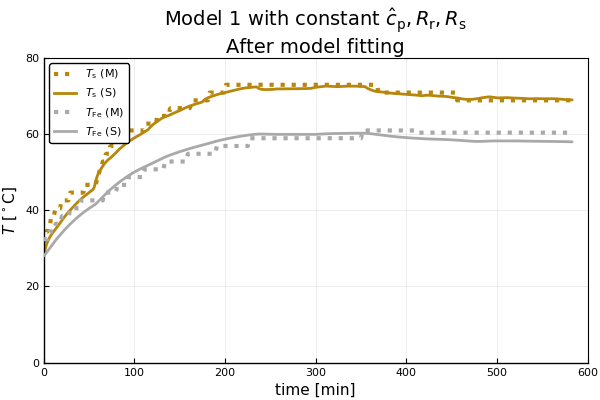

In [160]:
# setting optimized parameter
p=result.minimizer
# Parameters
# Initial values
x0 = [28.,28.,28.]
# Time span
tspan = (0., 583*60.)
prob = ODEProblem(gen,x0,tspan,p)
print("hello")
sol = solve(prob, ABM54(), dt=60)

plot(sol.t/60,Ts_meas_float,label=L"T_\mathrm{s}\ \mathrm{(M)}",lc=:darkgoldenrod,lw=3,ls=:dot)
plot!(sol.t/60,sol[2,:], label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(sol.t/60,TFe_meas_float,label=L"T_\mathrm{Fe}\ \mathrm{(M)}",lc=:darkgrey,lw=3,ls=:dot )
plot!(solPrev.t/60,solPrev[3,:], label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)

Model1afterFitting=plot!(title=string("Model 1 with constant ", "\$\\hatc_\\mathrm{p},R_\\mathrm{r},R_\\mathrm{s}\$\nAfter model fitting"),
    xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,600),ylim=(0,80),framestyle = :box,legend=:topleft)


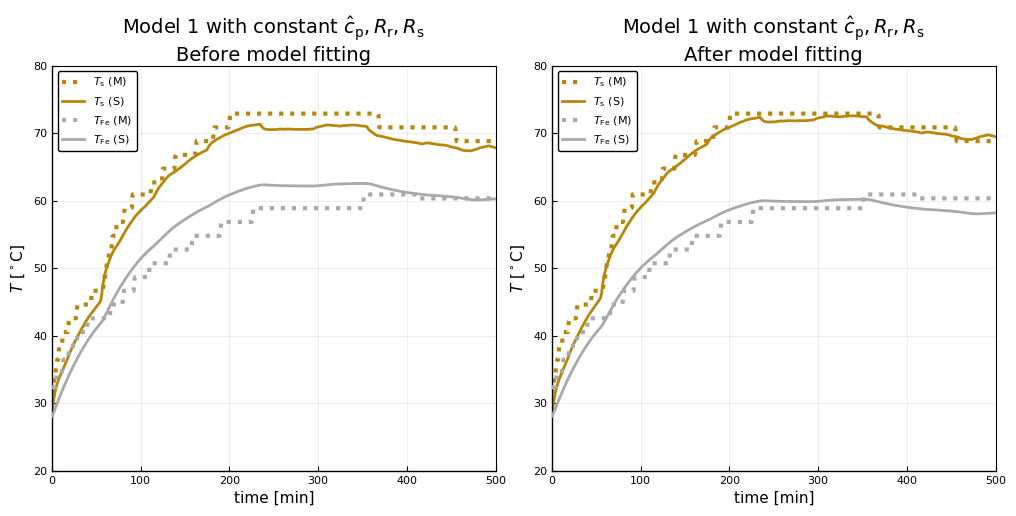

In [168]:
plot(Model1beforeFitting,Model1afterFitting,size=(1000,500),xlim=(0,500),ylim=(20,80))
